In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

## Treating missing data


In [2]:
# Load data from a CSV file
data = pd.read_csv('./data/HR_data.csv', index_col=0)

missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(inplace=True)

missing_rows = data.isnull().any(axis=1)
missing_cols = missing_data.index

data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,2.321429,1.892857,NaN,NaN,NaN,2.0,NaN
120,1.968750,2.703125,2.0,1.0,2.0,2.0,NaN
122,3.387500,2.367647,3.0,1.0,2.0,NaN,3.0
125,2.108696,1.911765,3.0,4.0,2.0,NaN,2.0
272,NaN,NaN,3.0,1.0,3.0,2.0,3.0


5 out of 302 rows have missing data, mainly in the questionaire answers. Instead of dropping the rows, we choose to impute the values by their mean withing the corresponding Cohort, Round, Phase and the Puzzler type. For the questionnaire values, the mean is rounded to the neares integer.

In [3]:
# Calculate mean of the column within the same Round, Phase, Puzzler and Cohort
means_for_missing = data.groupby(['Round', 'Phase', 'Puzzler', 'Cohort']).mean().reset_index()

# Replace missing values
for index, row in data.iterrows():
    if row.isnull().any():
        mean_row = means_for_missing[(means_for_missing['Round'] == row['Round']) 
                                     & (means_for_missing['Phase'] == row['Phase']) 
                                     & (means_for_missing['Puzzler'] == row['Puzzler']) 
                                     & (means_for_missing['Cohort'] == row['Cohort'])]
        
        # only replace the values that are missing
        for col in row[row.isnull()].index:
            # round the questionnaire values
            if col in ['attentive', 'afraid', 'active', 'inspired', 'determined']:
                data.at[index, col] = np.round(mean_row[col].values[0])
            else:
                data.at[index, col] = mean_row[col].values[0]

# Check that it works as expected
data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,2.321429,1.892857,3.0,1.0,2.0,2.0,3.0
120,1.968750,2.703125,2.0,1.0,2.0,2.0,2.0
122,3.387500,2.367647,3.0,1.0,2.0,2.0,3.0
125,2.108696,1.911765,3.0,4.0,2.0,2.0,2.0
272,2.557692,2.409091,3.0,1.0,3.0,2.0,3.0


## Emotion exploration

Lets try to combine questionnaire answers into one score by subtracting the negative emotions from the positive emotions.

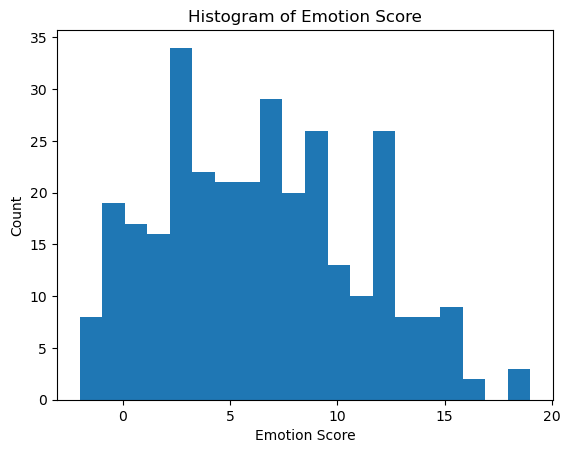

In [4]:
positive_emotions = ['active', 'alert', 'attentive', 'determined', 'inspired']
negative_emotions = ['afraid', 'ashamed', 'hostile', 'nervous', 'upset']

data['positive_score'] = data[positive_emotions].sum(axis=1)
data['negative_score'] = data[negative_emotions].sum(axis=1)
data['emotion_score'] = data['positive_score'] - data['negative_score']

plt.hist(data.emotion_score, bins=20);
plt.title('Histogram of Emotion Score')
plt.ylabel('Count')
plt.xlabel('Emotion Score')
plt.show()



However, a problem is that I-PANAS-SF is designed to measure both positive and negative affect, and it is important to consider both aspects when assessing emotional well-being. Combining the scores into one number would not provide a nuanced understanding of an individual's emotional state, as it would not distinguish between positive and negative affect. Therefore, we continue with an exploration where the negative and positive emotion resposes are summed, but kept separate.


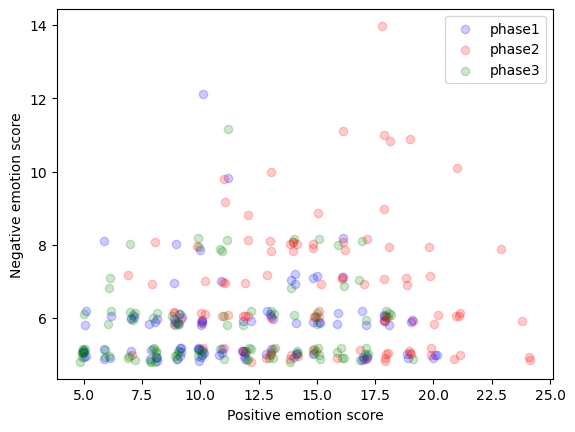

In [5]:
def jitter_points(data, jitter=0.2):
    return data + np.random.uniform(-jitter, jitter, size=len(data))

p_to_c = {'phase1': 'blue', 'phase2': 'red', 'phase3': 'green'}

for phase in sorted(data.Phase.unique()):
    plt.scatter(jitter_points(data[data.Phase == phase].positive_score),
                jitter_points(data[data.Phase == phase].negative_score),
                alpha=0.2, c=p_to_c[phase], label=phase)
plt.xlabel('Positive emotion score')
plt.ylabel('Negative emotion score')
plt.legend()
plt.show()

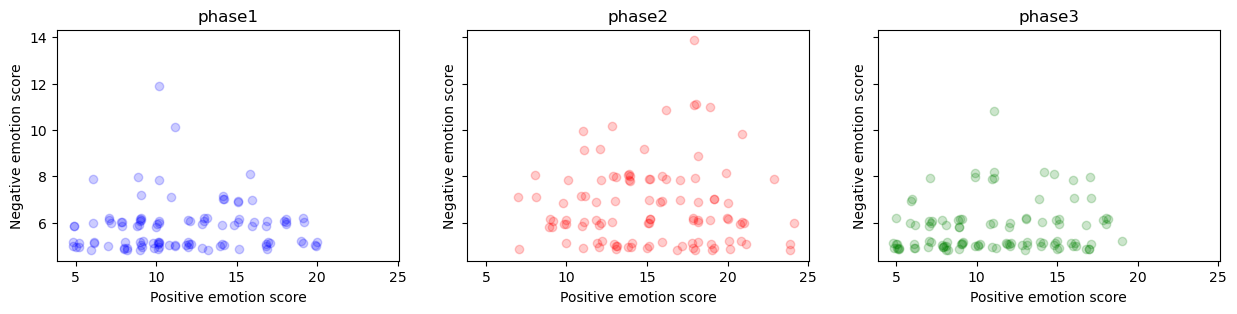

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True, sharex=True)

for i, phase in enumerate(['phase1', 'phase2', 'phase3']):
    axs[i].scatter(jitter_points(data[data.Phase == phase].positive_score),
                jitter_points(data[data.Phase == phase].negative_score),
                alpha=0.2, c=p_to_c[phase], label=phase)
    axs[i].set_title(phase)
    #axs[i].legend()
    axs[i].set_xlabel('Positive emotion score')
    axs[i].set_ylabel('Negative emotion score')
#plt.legend()
plt.show()

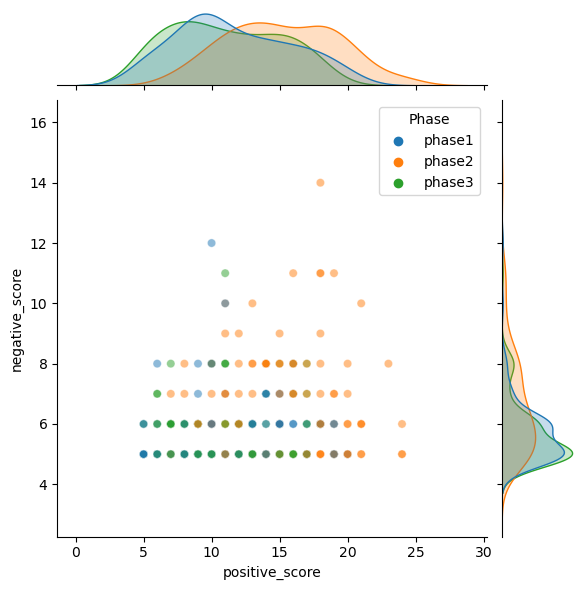

In [7]:
# alternative approach using seaborn, in this case without jitter but with KDEs on top

sns.jointplot(x='positive_score', y='negative_score', data=data, kind='scatter', alpha=0.5, hue='Phase', hue_order=['phase1', 'phase2', 'phase3'])
plt.show()

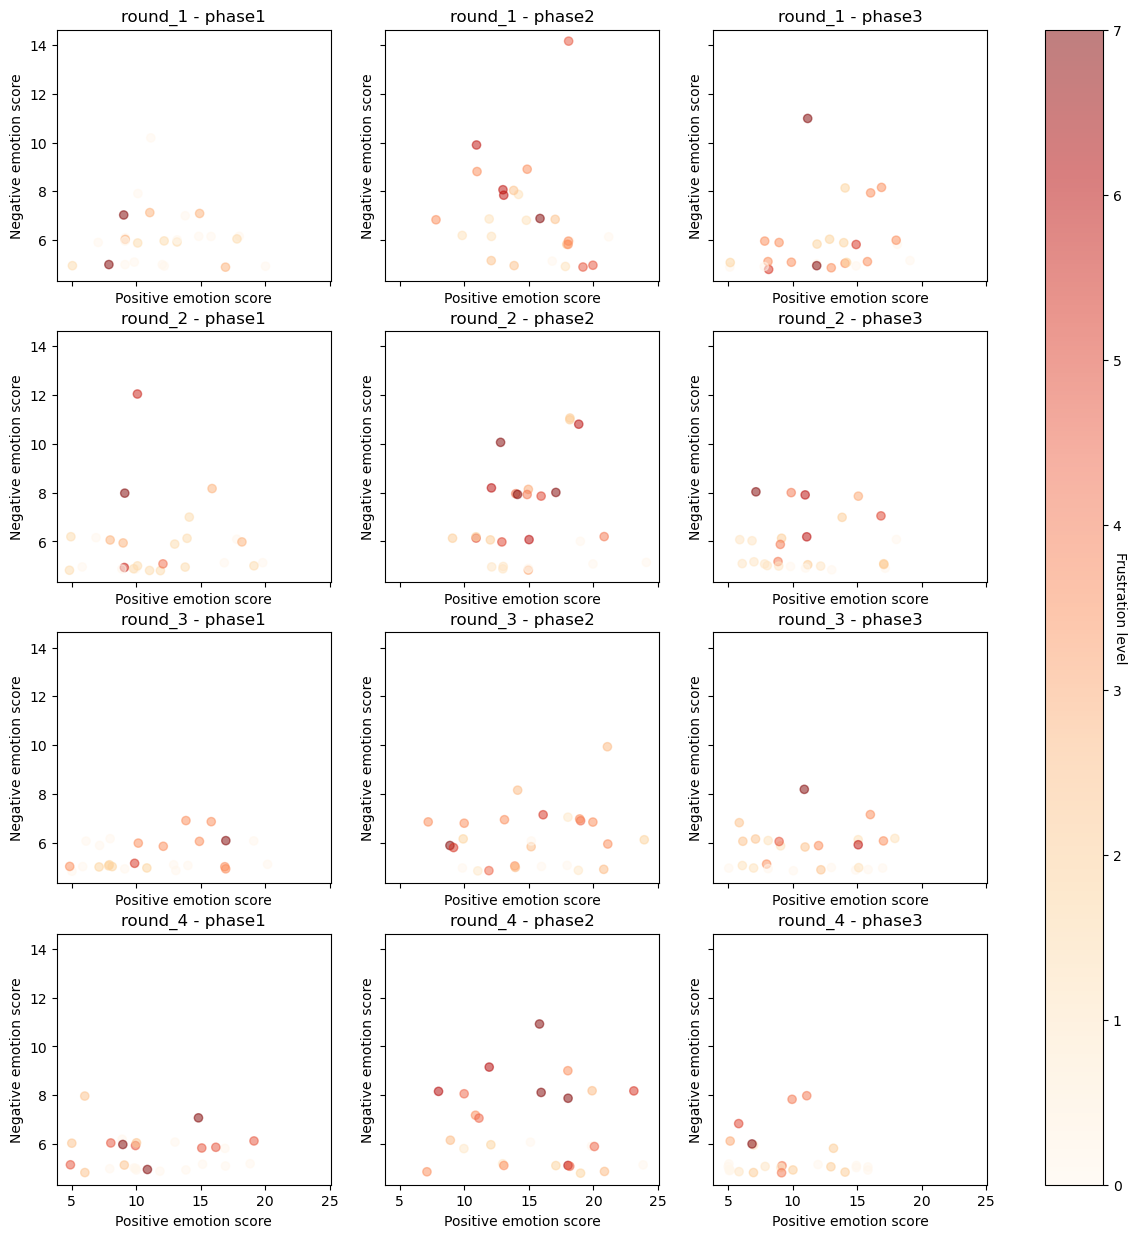

In [8]:
# emotions vs frustration level
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

jitter = True
for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        # X = standardize(split[num_cols])
        # kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
        if jitter: scat = axs[i, j].scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), alpha=0.5, c=split.Frustrated, cmap='OrRd')
        else: scat = axs[i, j].scatter(split.positive_score, split.negative_score, alpha=0.5, c=split.Frustrated, cmap='OrRd')
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')
cbar = fig.colorbar(scat, ax=axs)
cbar.ax.set_ylabel('Frustration level', rotation=270)
#plt.tight_layout()
plt.show()

Emotions throughout the rounds and phases with the color indicating the frustration level of the participants. The color is on a scale from 0 to 10, where 0 is light orange and 10 is dark red.

## Approach 1: Clustering within each round and phase and comparing to the questionnaire results

In [9]:
# The experiment was run on three separate occasions. D1_1 were completed in the winter and D1_2 and D1_3 were completed in the fall.
# D1_3 were conducted in four separate sessions; 
# D13_1 and D13_3 were completed in the morning and D13_2 and D13_4 were collected in the evening.
# For this case D1_3 has been divided into D1_3, D1_4, D1_5, D1_6
data.Cohort.value_counts()

Cohort
D1_1    96
D1_2    72
D1_4    48
D1_3    48
D1_6    24
D1_5    24
Name: count, dtype: int64

In [10]:
data.Round.value_counts()

Round
round_3    78
round_2    78
round_4    78
round_1    78
Name: count, dtype: int64

In [11]:
data.Phase.value_counts()

Phase
phase3    104
phase2    104
phase1    104
Name: count, dtype: int64

In [12]:
#cohort = 'D1_1'
round = 'round_1'
phase = 'phase1'

num_cols = data.columns[:51]
def standardize(X):
    X[num_cols] = (X[num_cols] - X[num_cols].mean()) / X[num_cols].std()
    return X

#split = data[(data.Cohort == cohort) & (data.Round == round) & (data.Phase == phase)]
split = data[(data.Round == round) & (data.Phase == phase)]

In [13]:
# cluster the data with K-means clustering
from sklearn.cluster import KMeans

X = standardize(split[num_cols])

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
kmeans.labels_


array([2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       2, 1, 1, 1], dtype=int32)

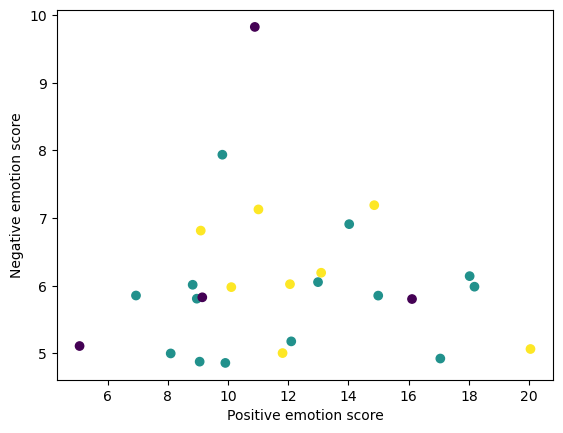

In [14]:
plt.scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), c=kmeans.labels_)
plt.xlabel('Positive emotion score')
plt.ylabel('Negative emotion score')
plt.show()

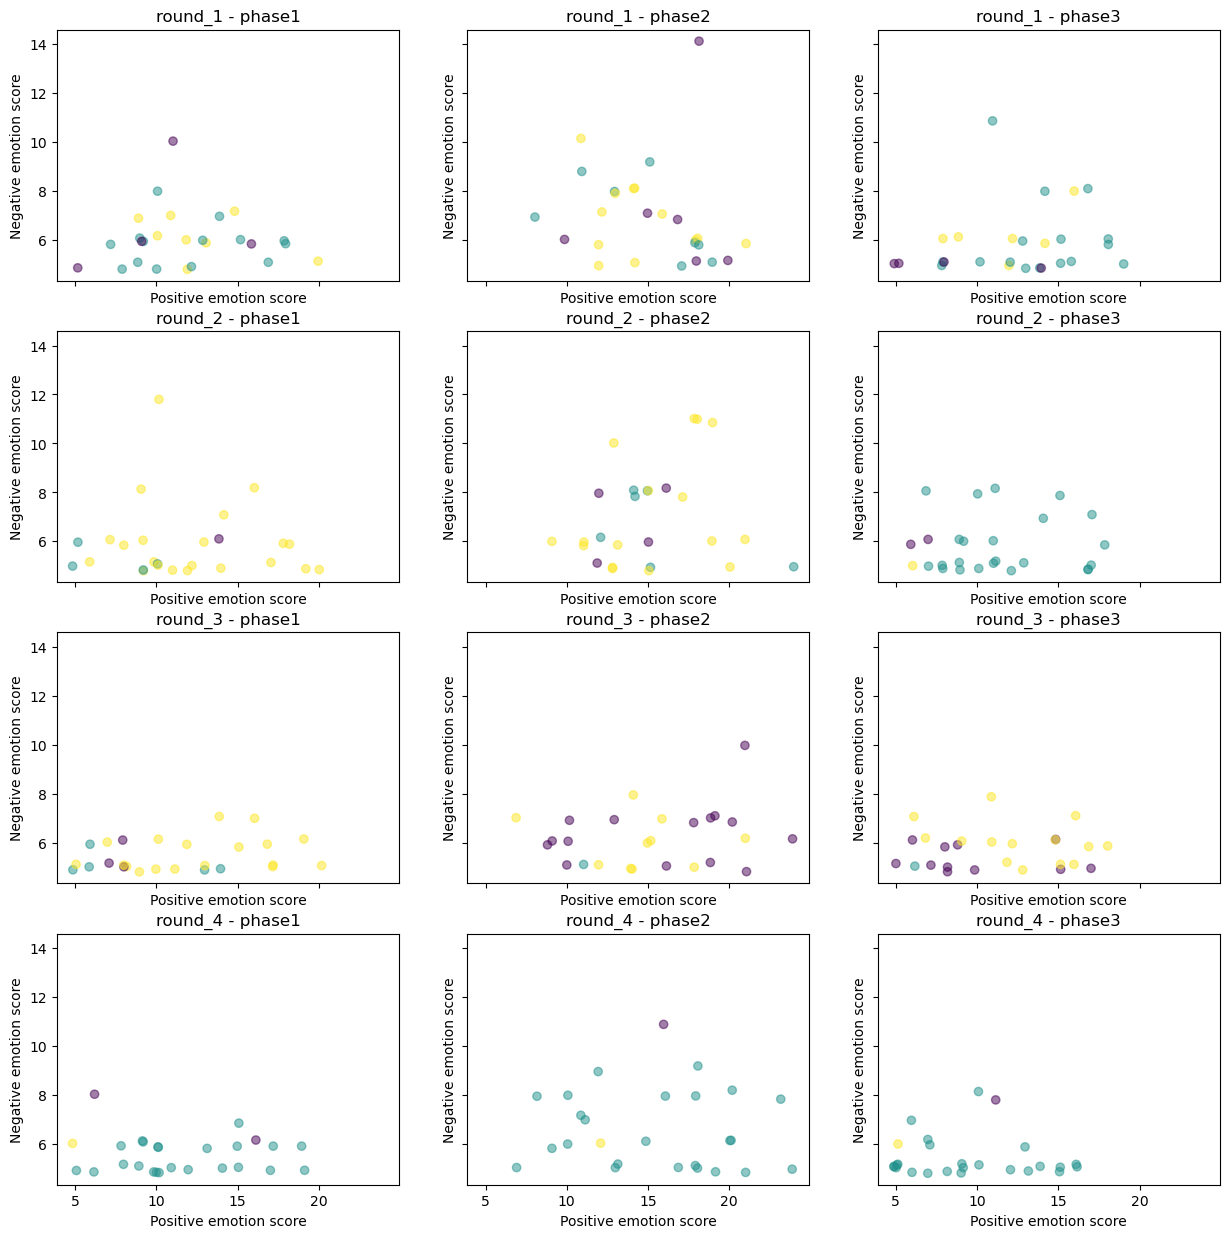

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        X = standardize(split[num_cols])
        kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
        axs[i, j].scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), c=kmeans.labels_, alpha=0.5)
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')


## Approach 2: Clustering globally and comparing to the questionnaire results within each round/phase

In [16]:
X = standardize(data[num_cols])

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
data['cluster'] = kmeans.labels_

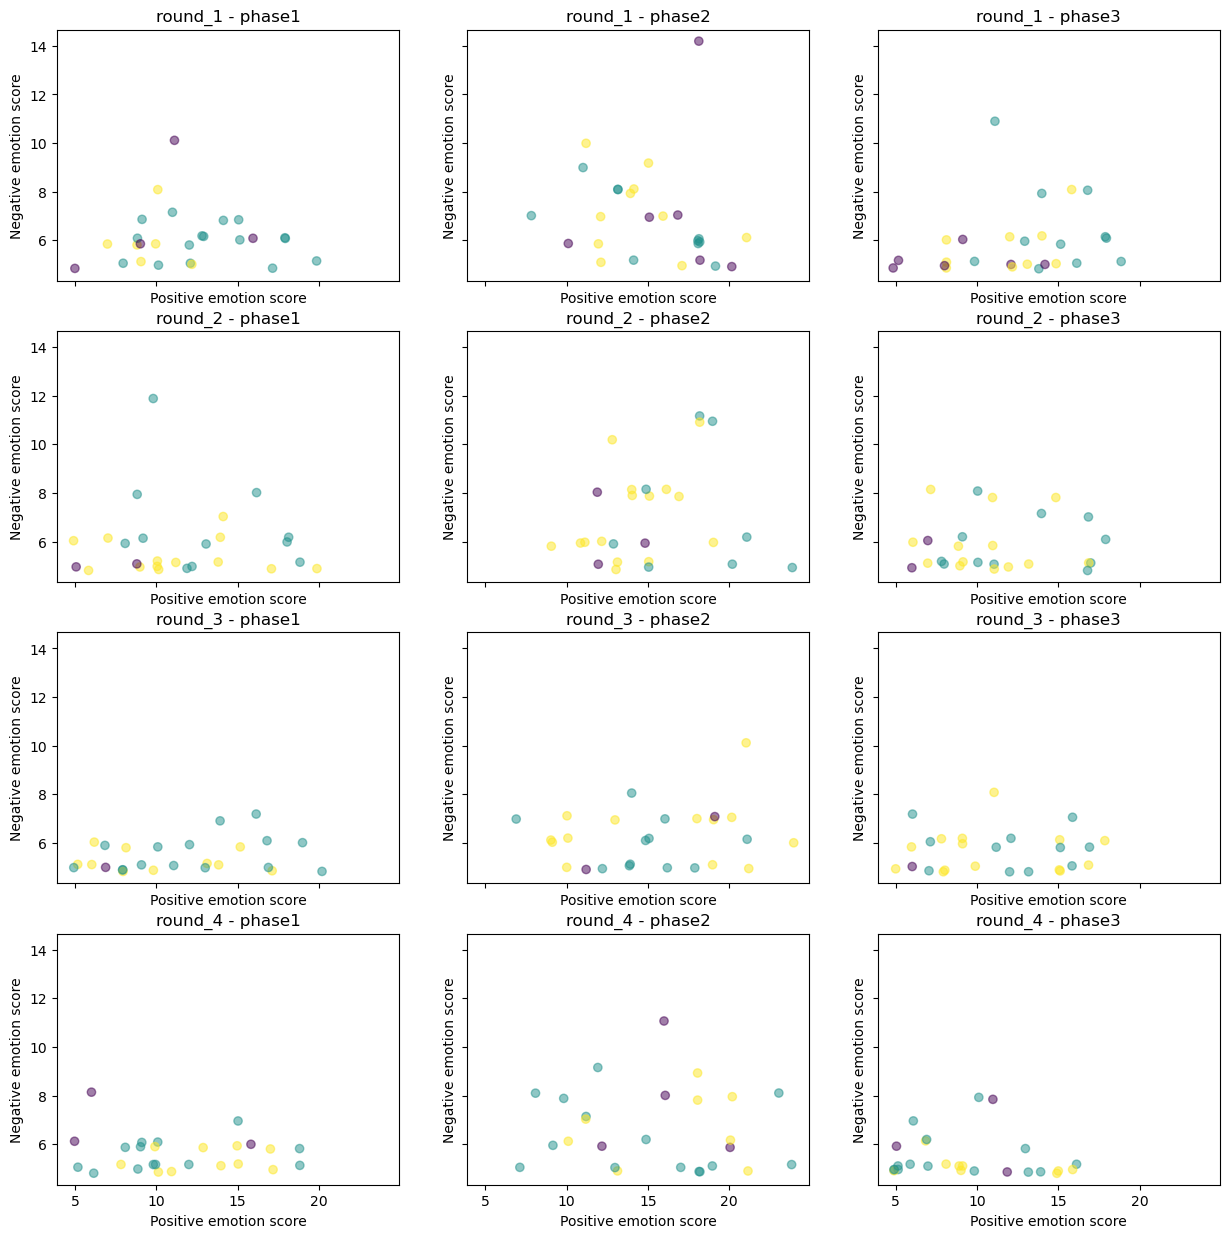

In [17]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15), sharey=True, sharex=True)

for i, round in enumerate(sorted(data.Round.unique())):
    for j, phase in enumerate(sorted(data.Phase.unique())):
        split = data[(data.Round == round) & (data.Phase == phase)]
        axs[i, j].scatter(jitter_points(split.positive_score), jitter_points(split.negative_score), c=split['cluster'], alpha=0.5)
        axs[i, j].set_title(f'{round} - {phase}')
        axs[i, j].set_xlabel('Positive emotion score')
        axs[i, j].set_ylabel('Negative emotion score')


## A quick inspection of the global clusters and frustration levels

<Axes: ylabel='Frequency'>

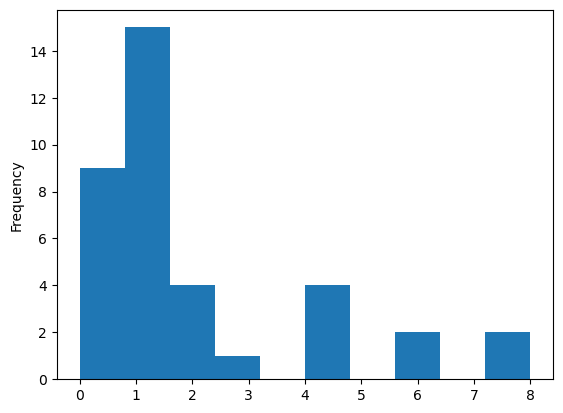

In [18]:
data[data['cluster'] == 0].Frustrated.plot.hist()

<Axes: ylabel='Frequency'>

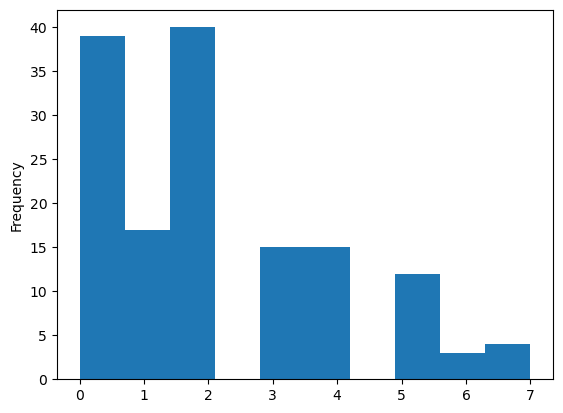

In [19]:
data[data['cluster'] == 1].Frustrated.plot.hist()

<Axes: ylabel='Frequency'>

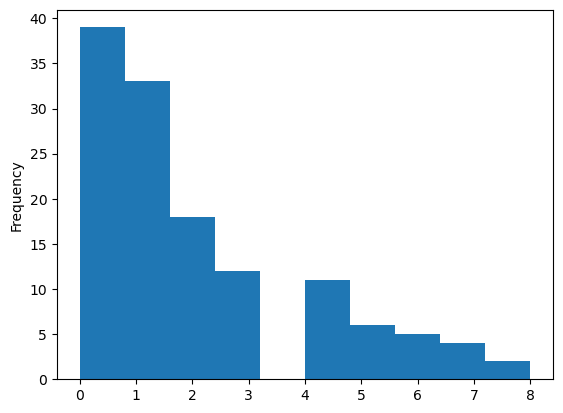

In [20]:
data[data['cluster'] == 2].Frustrated.plot.hist()